Проект e-commerce:
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?  

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. 

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt



In [2]:
# Укажем общие надстройки для графиков
sns.set(
    font_scale = 2,
    style      = "whitegrid",
    rc         = {'figure.figsize':(25,10)}
)

 Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

In [3]:

# - для начала определим что такое 'совершенноя покупка'? 
# критерии отбора : доставка продукта ,order_status == delivered,проверить что бы время доставки тоже было указано !  
# Почему  : покупка оплачена 100 %  и доставлена 100% ! - это 100 % совершённая покупка 


1.Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [4]:
# Считаем Таблицу с уникальными идентификаторами пользователей: 
olist_customers_dataset = pd.read_csv('C:/Users/NXY2/Downloads/olist_customers_dataset.csv')
olist_customers_dataset.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
# Проанализируем Таблицу с уникальными идентификаторами пользователей: 
# - Есть пользователи которые совершыли более 1 покупки, самое большое количесвто покупок совершил пользователь с 
#  уникальным идентификатором customer_unique_id=='8d50f5eadf50201ccdcedfb9e2ac8455'
olist_customers_dataset.value_counts('customer_unique_id') 


customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
                                    ..
5657dfebff5868c4dc7e8355fea865c4     1
5657596addb4d7b07b32cd330614bdf8     1
5656eb169546146caeab56c3ffc3d268     1
5656a8fabc8629ff96b2bc14f8c09a27     1
ffffd2657e2aad2907e67c3e9daecbeb     1
Length: 96096, dtype: int64

In [6]:
# Всего количесвто customer_unique_id совершивших покупки : 96096
len(olist_customers_dataset.value_counts('customer_unique_id'))

96096

In [7]:
# А сколько всего они совершили заказов: 99441 
len(olist_customers_dataset.value_counts('customer_id'))


99441

In [8]:
#считаем и проанализируем Таблицу заказов : 
# - Как мы можем видеть 96478 заказов имеют статус доставлен Но не учтен Фактор времени!!!! 
olist_orders_dataset=pd.read_csv('C:/Users/NXY2/Downloads/olist_orders_dataset.csv')
olist_orders_dataset.value_counts('order_status').reset_index()

,order_status,0
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [9]:
# проверим нашу Таблицу заказов на пропущенные значения: 
#- отчетливо видно что 
# 1. Количество пропущенного "Времени подтверждения оплаты заказа" order_approved_at == 160 
# 2. Количество пропущенного"времени передачи заказа в логистическую службу" order_delivered_carrier_date == 1783
# 3. Количество пропущенного "Время доставки заказа" order_delivered_customer_date == 2965
olist_orders_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [10]:
# В задаче нас просят найти пользователей совершивших только 1 покупку, для решения этой задачи нужно объеденить 
# Таблицу с уникальными идентификаторами пользователей & Таблицу заказов :
all_customers_orders_dataset=olist_customers_dataset.merge(olist_orders_dataset, how='inner', on='customer_id')
all_customers_orders_dataset.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00


In [11]:
# проверим нашу Таблицу с уникальными идентификаторами пользователей & Таблицу заказов,предварительно  отобрав 
# по статусу delivered' ,на пропущенные значения:
#    - отчетливо видно что:
# 1. Количество пропущенного "Времени подтверждения оплаты заказа" order_approved_at == 14
# 2. Количество пропущенного"времени передачи заказа в логистическую службу" order_delivered_carrier_date == 2
# 3. Количество пропущенного "Время доставки заказа" order_delivered_customer_date == 8

all_customers_orders_dataset.query("order_status=='delivered'").isna().sum()

customer_id                       0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
order_id                          0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [12]:
# Данные о пропущенном времени прийдется убрать, так как эти пропущенные значения могут указывать на
 #- или заказ не оплачен 
 #- или заказ не отправлен в логистическую службу /не доставлен 
 #- или заказ вообще не доставлен пользователю 
 # Отберем и посчитаем пользователей  со статусом = Доставлен ('delivered'), убрав все значения  пропущенного времени
customer_unique_per_delivered = all_customers_orders_dataset.query("order_status=='delivered'").dropna()\
                            .value_counts('customer_unique_id')\
                            .reset_index()\
                            .rename(columns={0:'counts'})
customer_unique_per_delivered

    

,customer_unique_id,counts
0,8d50f5eadf50201ccdcedfb9e2ac8455,15
1,3e43e6105506432c953e165fb2acf44c,9
2,1b6c7548a2a1f9037c1fd3ddfed95f33,7
3,ca77025e7201e3b30c44b472ff346268,7
4,6469f99c1f9dfae7733b25662e7f1782,7
...,...,...
93331,5657dfebff5868c4dc7e8355fea865c4,1
93332,5657596addb4d7b07b32cd330614bdf8,1
93333,5656eb169546146caeab56c3ffc3d268,1
93334,5656a8fabc8629ff96b2bc14f8c09a27,1


In [13]:
# отберем пользователей совершивших только 1 покупку , посчитаем их количесвто = 90536                
customer_per_delivery_1 = customer_unique_per_delivered[customer_unique_per_delivered.counts==1].shape[0]
customer_per_delivery_1     
    

90536

2.Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

In [14]:
#Заказы могут не прибывать по разным причинам = изминение статуса тому доказательство .Все заказы и так же delivered с   
# отсутсвующим временем ,войдут в эту категорию, так как ни один последующий статус не дает 100 % доставки. Например в shipped 
# - отгружен со склада.
#но по пути может произойти авария - заказ будет отменен, в том и логика статуса заказа постоянно меняться - и показывать в
# какой точке цепи находится заказ 

In [15]:
# Создадим колонку в обЪедененном ДФ , с датами по месяцам 
all_customers_orders_dataset['data_order_purchase'] =  all_customers_orders_dataset\
                                                      .order_purchase_timestamp\
                                                      .apply(lambda x: x[0:7])

In [16]:
# Посмотрим общее количество причин недоставки товаров, включая пробелы во времени
# ...delevered _(2) ,...approved_ (1) == время 0 
all_customers_orders_dataset.fillna(0)\
                            .query("order_delivered_carrier_date==0 or\
                                    order_approved_at == 0 or \
                                    order_delivered_customer_date==0 ")\
                            .value_counts('order_status')

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered        23
created           5
approved          2
dtype: int64

In [17]:
# Создадим Таблицу с групировкой по месяцам, статусом и количеством заказов 
for_mean_per_month = all_customers_orders_dataset.fillna(0).query("order_delivered_carrier_date==0 or order_approved_at == 0 or order_delivered_customer_date==0 ")\
                                                 .groupby(['data_order_purchase','order_status'],as_index=False)\
                                                 .agg({'customer_unique_id':'count'})\
                                                 .rename(columns={'customer_unique_id':'count_n'})

In [18]:
for_mean_per_month

,data_order_purchase,order_status,count_n
0,2016-09,canceled,2
1,2016-09,shipped,1
2,2016-10,canceled,19
3,2016-10,invoiced,18
4,2016-10,processing,2
...,...,...,...
115,2018-08,shipped,47
116,2018-08,unavailable,7
117,2018-09,canceled,15
118,2018-09,shipped,1


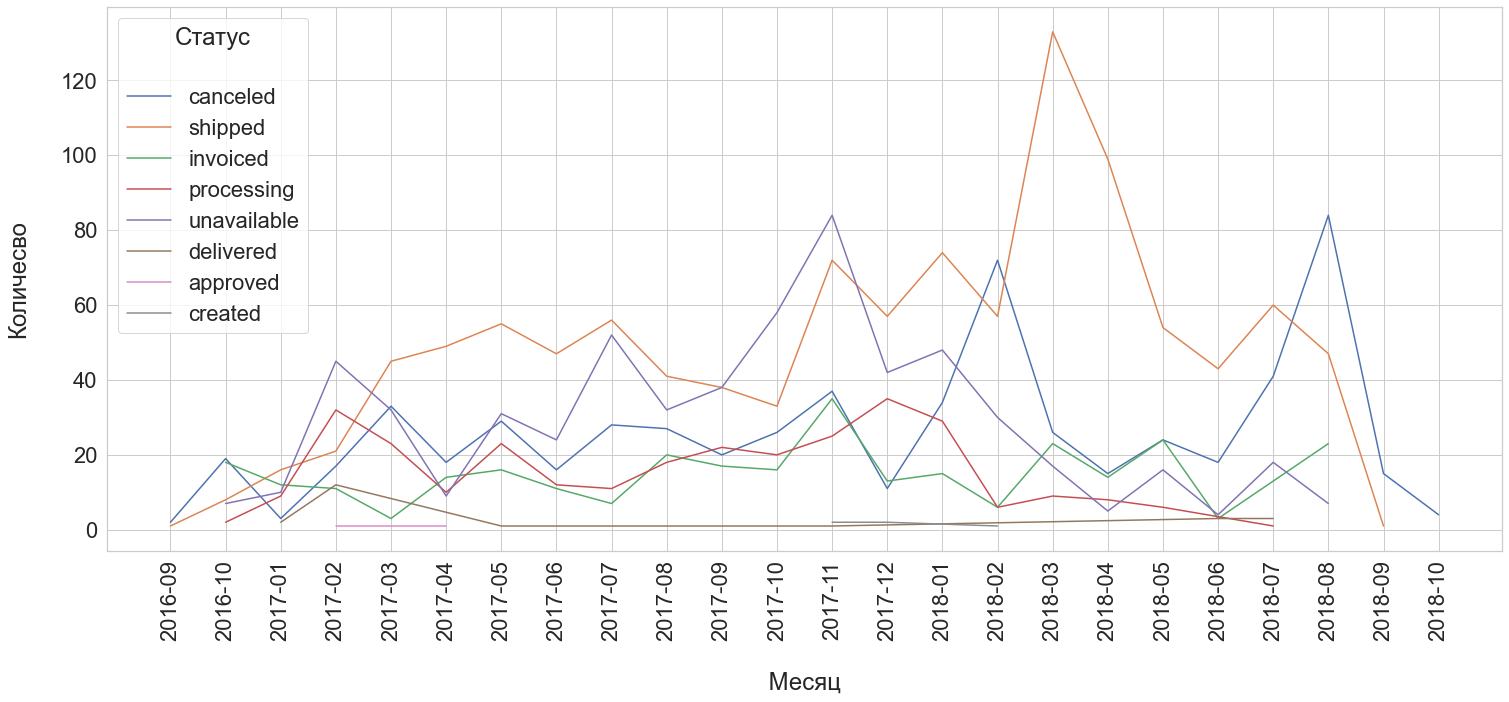

In [19]:
# График количесвта недоставки  по месяцам - в зависимости от причины:  
# !DELIVERED! - в нашем случае недоставка по причине отсутсвия дат оплаты, даты доставки, даты отправки!
ax=sns.lineplot(x='data_order_purchase',y='count_n',hue='order_status',data=for_mean_per_month)
ax.tick_params(axis='x',rotation = 90 )
ax.set_xlabel('\n Месяц ')
ax.set_ylabel('Количесво\n')
plt.legend(title='Статус\n')
plt.show()


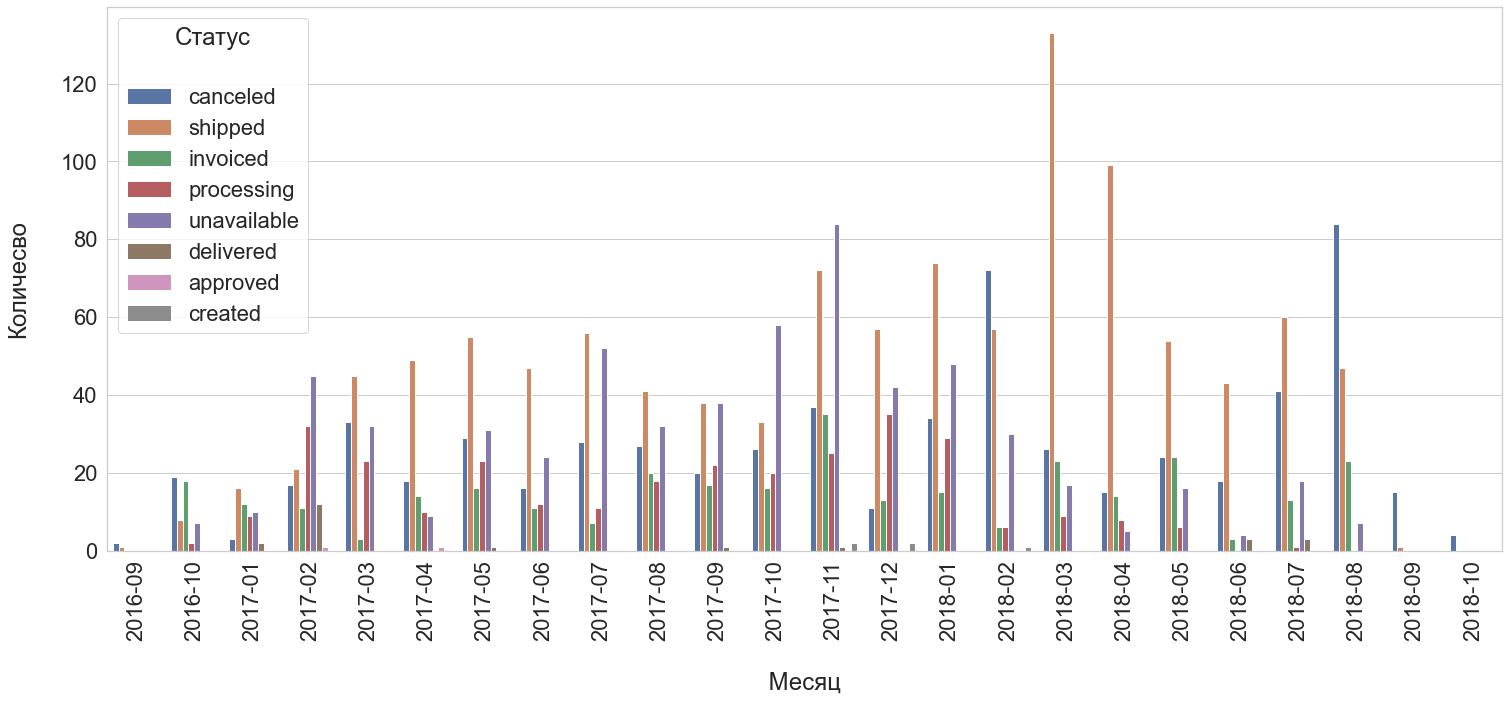

In [20]:
# График количесвта недоставки  по месяцам - в зависимости от причины:  
# !DELIVERED! - в нашем случае недоставка по причине отсутсвия оплаты, даты доставки, даты отправки!
ax=sns.barplot(x='data_order_purchase',y='count_n',hue='order_status',data=for_mean_per_month)
ax.tick_params(axis='x',rotation = 90 )
ax.set_xlabel('\n Месяц ')
ax.set_ylabel('Количесво\n')
plt.legend(title='Статус\n')
plt.show()


In [21]:
# количества недоставки заказов помесячно:
count_per_month = for_mean_per_month.groupby('data_order_purchase',as_index=False).sum()
count_per_month.head()

,data_order_purchase,count_n
0,2016-09,3
1,2016-10,54
2,2017-01,52
3,2017-02,139
4,2017-03,136


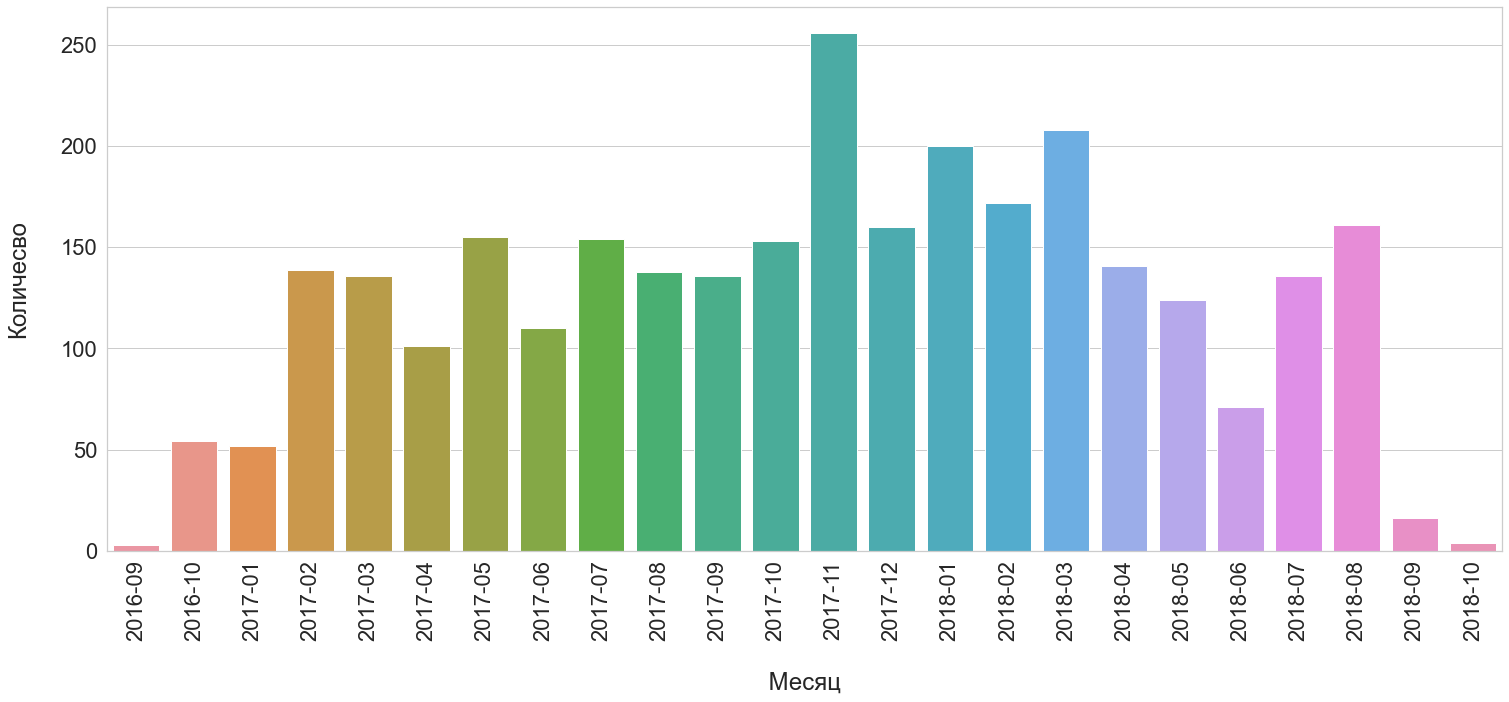

In [22]:
# График количества недоставки заказов помесячно , создан для удобсва визуализации и чтения предыдущего графика. 
ax=sns.barplot(x='data_order_purchase', y='count_n' ,data=count_per_month)
ax.tick_params(axis='x',rotation = 90 )
ax.set_xlabel('\n Месяц ')
ax.set_ylabel('Количесво\n')
plt.show()


In [23]:
# Описательные статистики количества недоставки заказов в месяц :
count_per_month.describe()

,count_n
count,24.000000
mean,124.166667
std,63.721996
min,3.000000
25%,93.500000
50%,137.000000
75%,156.250000
max,256.000000


In [24]:
# Среднее кол-во недоставки заказов  в месяц ( округленное до целого) = 124  :
mean_per_month= count_per_month.count_n.mean()
round(mean_per_month)

124

3.По каждому товару определить, в какой день недели товар чаще всего покупается.
   


In [25]:
# так как товар указан в таблице Товарные позиции, входящие в заказы - считаем эту таблицу.
olist_order_items_dataset = pd.read_csv('C:/Users/NXY2/Downloads/olist_order_items_dataset.csv')


In [26]:
# Как видим из длины olist_order_items_dataset(112650) -
# количество строк отличается от кол-ва в общем all_customers_orders_dataset (99441)
# Посараемся проанализировать olist_order_items_dataset и выявить закономерности.
len(olist_order_items_dataset) 

112650

In [27]:
# визуализируем olist_order_items_dataset с order_id == '00143d0f86d6fbd9f9b38ab440ac16f5':
# Возможно купили в один чек (order_id ) - три товара  
olist_order_items_dataset[olist_order_items_dataset.order_id == '00143d0f86d6fbd9f9b38ab440ac16f5']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [28]:
# Проверим данное утверждение  - вызвав метод подсчета уникальных значений:
olist_order_items_dataset.value_counts('order_id')

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
5a0911d70c1f85d3bed0df1bf693a6dd     1
5a082b558a3798d3e36d93bfa8ca1eae     1
5a07264682e0b8fbb3f166edbbffc6e8     1
5a071192a28951b76774e5a760c8c9b7     1
fffe41c64501cc87c801fd61db3f6244     1
Length: 98666, dtype: int64

In [29]:
# Подтвердим догадку по самому "длинному" чеку:
# Утверждение верно ! 
olist_order_items_dataset[olist_order_items_dataset.order_id == '8272b63d03f5f79c56e9e4120aec44ef'].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [30]:
# соберем все успешные ордер_id, не забываем убрать все неизвестные значения которые мы определили до этого: 
name_delivered_order_id = all_customers_orders_dataset.query("order_status=='delivered'").dropna()\
                            .value_counts('order_id')\
                            .reset_index()\
                            .rename(columns={0:'counts'}).order_id
name_delivered_order_id 

0        00010242fe8c5a6d1ba2dd792cb16214
1        ab2e481b1ef043b41c202628100f6b4b
2        ab348b95012031ab6a86594395ad47e1
3        ab344aaf7040ad7bcee8c7ae7db9e87e
4        ab30f8d4ebb7d33d1dcf54d420ea42cd
                       ...               
96450    555bdeeec0ae00faeb547748b9e58ec6
96451    555b96fab13352cfb0199d765806f364
96452    555abbd521ea234b5a6b908bb132244b
96453    5559edd02dabfec0a6ee808960297d1b
96454    fffe41c64501cc87c801fd61db3f6244
Name: order_id, Length: 96455, dtype: object

In [31]:
# только успешные заказы отобраны в olist_order_items_dataset: 
olist_order_items_dataset = olist_order_items_dataset.query("order_id in @name_delivered_order_id")
olist_order_items_dataset

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [32]:
# добавим колонку о времени заказа из большого ДФ , достаточно провести обьеденение по order_id:
data_order_items_dataset = olist_order_items_dataset\
                          .merge(all_customers_orders_dataset[['order_id','order_purchase_timestamp']],\
                                                                            how='left', on='order_id')

In [33]:
# изменим тип колонки с датами на datetime:
data_order_items_dataset.order_purchase_timestamp = pd.to_datetime(data_order_items_dataset.order_purchase_timestamp)

In [34]:
# создадим новую колонку с днями недели : 
data_order_items_dataset['day_name']=data_order_items_dataset.order_purchase_timestamp.dt.day_name()
data_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,day_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,Saturday


In [35]:
# Найдем самые часто встречаемые товары по дням недели :
name_day_max_prod_id = data_order_items_dataset.groupby(['day_name','product_id'])\
                         .agg({'seller_id':'count'}).reset_index()\
                         .groupby('day_name',as_index=False).max()\
                         .rename(columns={'seller_id':'max_count'})
name_day_max_prod_id                           

,day_name,product_id,max_count
0,Friday,fffdb2d0ec8d6a61f0a0a0db3f25b441,83
1,Monday,fff81cc3158d2725c0655ab9ba0f712c,91
2,Saturday,fff6177642830a9a94a0f2cba5e476d1,59
3,Sunday,fffdb2d0ec8d6a61f0a0a0db3f25b441,61
4,Thursday,fffdb2d0ec8d6a61f0a0a0db3f25b441,89
5,Tuesday,fffdb2d0ec8d6a61f0a0a0db3f25b441,85
6,Wednesday,fffe9eeff12fcbd74a2f2b007dde0c58,93


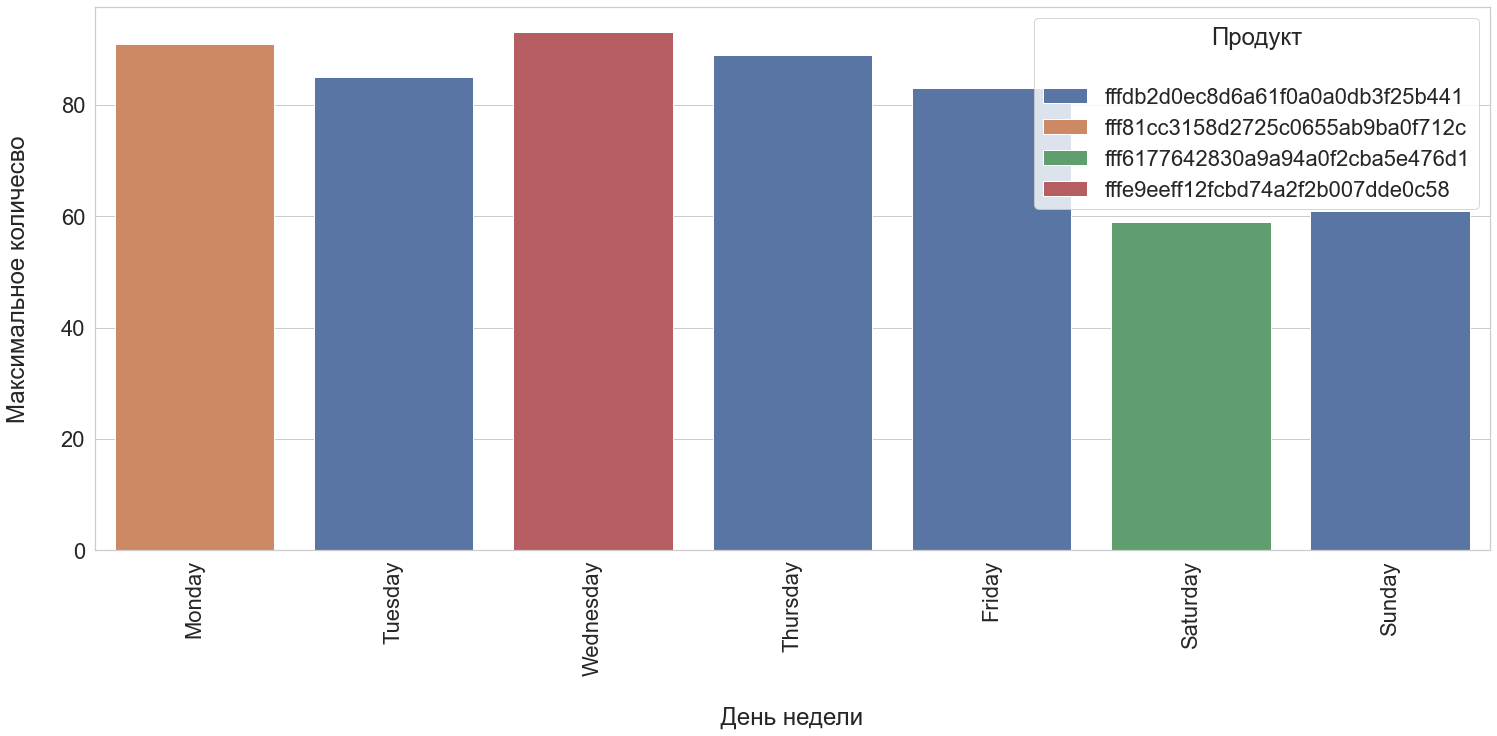

In [36]:
ax=sns.barplot(x='day_name',y= 'max_count',data= name_day_max_prod_id,\
            order=['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'],hue='product_id',dodge=False)
ax.tick_params(axis='x', rotation = 90)
ax.set_xlabel('\n День недели ')
ax.set_ylabel('Максимальное количесво\n')
plt.legend(title='Продукт\n')
plt.show()


4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
 Не стоит забывать, что внутри месяца может быть не целое количество недель. 
 Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [37]:
# Подумаем о метрике , что значит сколько покупок в неделю по месяцам ?
# возможно нужно использовать колчество покупок в месяц / количество недель в месяце:
# например если у меня всего 10 покупок в месяц / 4 недели = 2,5 покупки 

In [38]:
# найдем сколько успешных покупок совершает помесячно каждый пользователь
ddt=all_customers_orders_dataset.query("order_status=='delivered'")\
                                .dropna().groupby(['data_order_purchase','customer_unique_id'])\
                                .agg({'order_id':'count'}).rename(columns={'order_id':'count_id'})\
                                .reset_index()
ddt.head()

,data_order_purchase,customer_unique_id,count_id
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,1
1,2016-10,0032c76b20340da25249092a268ce66c,1
2,2016-10,01f156677184504063bd19739f924af1,1
3,2016-10,0636d30c77f0f9cfad81f1c9b58c791f,1
4,2016-10,06bdfbbe1857c3c925ec81abfb1c9666,1


In [39]:
# для того что бы узнать сколько недель в месяце переведем колонку в day time:
ddt.data_order_purchase = pd.to_datetime(ddt.data_order_purchase)

In [40]:
# количество недель в месяце найдем по - количество дней в месяце / количесво дней в неделе ( 7) - для удобсвта создадим новую
# колонку и сразу посчитаем метрику : количество покупок в месяце / количество недель в месяце :
ddt['mean_per_week']=ddt.count_id/(ddt.data_order_purchase.dt.days_in_month/7)

In [41]:
ddt

,data_order_purchase,customer_unique_id,count_id,mean_per_week
0,2016-09-01,830d5b7aaa3b6f1e9ad63703bec97d23,1,0.233333
1,2016-10-01,0032c76b20340da25249092a268ce66c,1,0.225806
2,2016-10-01,01f156677184504063bd19739f924af1,1,0.225806
3,2016-10-01,0636d30c77f0f9cfad81f1c9b58c791f,1,0.225806
4,2016-10-01,06bdfbbe1857c3c925ec81abfb1c9666,1,0.225806
...,...,...,...,...
95166,2018-08-01,ffc39051848c3ef2be36d1513aa3ad17,1,0.225806
95167,2018-08-01,ffc4e1cd8aa220763480d0a18157c45d,1,0.225806
95168,2018-08-01,ffe204b1bb8026741b839085b2fd10f2,1,0.225806
95169,2018-08-01,ffec490ab531184a483efe2eedd68908,1,0.225806


In [42]:
# Проверка
#Для удобства используем выборку по customer_unique_id: 
ddt[ddt.customer_unique_id=='8d50f5eadf50201ccdcedfb9e2ac8455']

,data_order_purchase,customer_unique_id,count_id,mean_per_week
12587,2017-06-01,8d50f5eadf50201ccdcedfb9e2ac8455,1,0.233333
16059,2017-07-01,8d50f5eadf50201ccdcedfb9e2ac8455,2,0.451613
20054,2017-08-01,8d50f5eadf50201ccdcedfb9e2ac8455,1,0.225806
24072,2017-09-01,8d50f5eadf50201ccdcedfb9e2ac8455,1,0.233333
28355,2017-10-01,8d50f5eadf50201ccdcedfb9e2ac8455,2,0.451613
34349,2017-11-01,8d50f5eadf50201ccdcedfb9e2ac8455,1,0.233333
73710,2018-05-01,8d50f5eadf50201ccdcedfb9e2ac8455,2,0.451613
86111,2018-07-01,8d50f5eadf50201ccdcedfb9e2ac8455,2,0.451613
92320,2018-08-01,8d50f5eadf50201ccdcedfb9e2ac8455,3,0.677419


In [43]:
# Но в задаче просили именно КАЖДОГО ПОЛЬЗОВАТЕЛЯ ПО МЕСЯЧНО!
# Обращаем внимание  на ДФ - длина : 93336 строк. 
# используем сводные таблицы : 

In [44]:
ddt_pivot = ddt.pivot(index='customer_unique_id',columns='data_order_purchase',values='mean_per_week')
ddt_pivot

data_order_purchase,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.225806,NaN,NaN,NaN
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.225806,NaN,NaN,NaN
0000f46a3911fa3c0805444483337064,NaN,NaN,NaN,NaN,NaN,0.225806,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000f6ccb0745a6a4b88665a16c9f078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0004aac84e0df4da2b147fca70cf8255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.233333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fffea47cd6d3cc0a88bd621562a9d061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.225806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ffff371b4d645b6ecea244b27531430a,NaN,NaN,NaN,NaN,0.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# проверка длины оригинального ДФ с успешно купленными товарами: длина 93336
all_customers_orders_dataset[all_customers_orders_dataset.order_status =='delivered'].dropna()\
                                                                                     .value_counts('customer_unique_id')

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    15
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
5657dfebff5868c4dc7e8355fea865c4     1
5657596addb4d7b07b32cd330614bdf8     1
5656eb169546146caeab56c3ffc3d268     1
5656a8fabc8629ff96b2bc14f8c09a27     1
ffffd2657e2aad2907e67c3e9daecbeb     1
Length: 93336, dtype: int64

In [46]:
# Длина совпадает с длиной успешно купленных ! 

5. Используя pandas, проведи когортный анализ пользователей.
В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 



In [47]:
# Когорта - это группа клиентов, обьеденненая по временному признаку : Группа людей  первый раз купившая товар за единицу
# времени . В нашем случае - за месяц. 
# retention - это количесво клиентов из кагорты, купивший повторный раз в следующие периоды .Длина периода - год , помесячно.

In [48]:
# используем исходный ДФ - в котором собраны покупки каждого пользователя помесячно : 
ddt.head()

,data_order_purchase,customer_unique_id,count_id,mean_per_week
0,2016-09-01,830d5b7aaa3b6f1e9ad63703bec97d23,1,0.233333
1,2016-10-01,0032c76b20340da25249092a268ce66c,1,0.225806
2,2016-10-01,01f156677184504063bd19739f924af1,1,0.225806
3,2016-10-01,0636d30c77f0f9cfad81f1c9b58c791f,1,0.225806
4,2016-10-01,06bdfbbe1857c3c925ec81abfb1c9666,1,0.225806


In [49]:
# Создадим когорты - группы людей, купившие впервые помесячно : 
user = ddt.groupby('customer_unique_id')['data_order_purchase'].min().reset_index()

In [50]:
user.head()

,customer_unique_id,data_order_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01


In [51]:
# Зададим период - год от января по декабрь ( в нашем ДФ есть только за 2017 год )
month = pd.DataFrame(pd.date_range('2017-01-01','2017-12-01',freq='MS'))

In [52]:
# Переименуем колонку в month
month.columns=['month']

In [53]:
month

,month
0,2017-01-01
1,2017-02-01
2,2017-03-01
3,2017-04-01
4,2017-05-01
5,2017-06-01
6,2017-07-01
7,2017-08-01
8,2017-09-01
9,2017-10-01


In [54]:
# Создадим суррогатные ключи  - для дальнейшего обьеденения ДФ. 
user['key'] = 1
month['key'] = 1

In [55]:
# Обьеденим ДФ user & month во временную таблицу по ключу key:
template = user.merge(month, on='key')[['customer_unique_id','data_order_purchase','month']]
template.head()

,customer_unique_id,data_order_purchase,month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-01-01
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-02-01
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-03-01
3,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-04-01
4,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-05-01


In [56]:
# Немного сократим нашу таблицу, отобрав только значения по нашему Периоду: 
template=template[template['month']>=template['data_order_purchase']]
template.head()

,customer_unique_id,data_order_purchase,month
26,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01
27,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01
28,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01
29,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01
30,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01


In [57]:
# Подготовим наш исходный ДФ для объеденения , отобрав нужные столбцы и переименовав колонку data_order_purchase в month , 
# для джойна иенно по Этим двум колонкам: 
ddt_rename = ddt[['customer_unique_id','data_order_purchase','count_id']].rename(columns={'data_order_purchase':'month'})
ddt_rename.head()

,customer_unique_id,month,count_id
0,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01,1
1,0032c76b20340da25249092a268ce66c,2016-10-01,1
2,01f156677184504063bd19739f924af1,2016-10-01,1
3,0636d30c77f0f9cfad81f1c9b58c791f,2016-10-01,1
4,06bdfbbe1857c3c925ec81abfb1c9666,2016-10-01,1


In [58]:
# Проводим джойн двух ДФ , template & ddt_rename , левое преобразование которое нам даст наши группы покупавших в указанные даты
report = template.merge(ddt_rename,on=['customer_unique_id','month'] , how='left')
report.head()

,customer_unique_id,data_order_purchase,month,count_id
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN


In [59]:
# Для подготовки немного поработаем с ДФ  перед преобразованием в сводные таблицы , добавим колонку active - где отобразится , 
# была покупка или нет этим юзером 
report['active'] = (report.count_id>0)*1
report.head()

,customer_unique_id,data_order_purchase,month,count_id,active
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0,1
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN,0
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN,0
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN,0


In [60]:
# преоразуем для дальейшей работы в хитмепе : 
report[['data_order_purchase','month']] = report[['data_order_purchase','month']].astype(str)

In [61]:
# Создадим сводную таблицу : Индекс - дата первой покупки (data_order_purchase) , колонки -годичный интервал ( помесячно )
# Сразу посчитаем процент ретеншин используя функцию -  среднее ( сразу даст нам % от активных / размер кагорты )
retention = report.pivot_table(index='data_order_purchase',columns='month',values='active',aggfunc='mean')
retention = retention*100

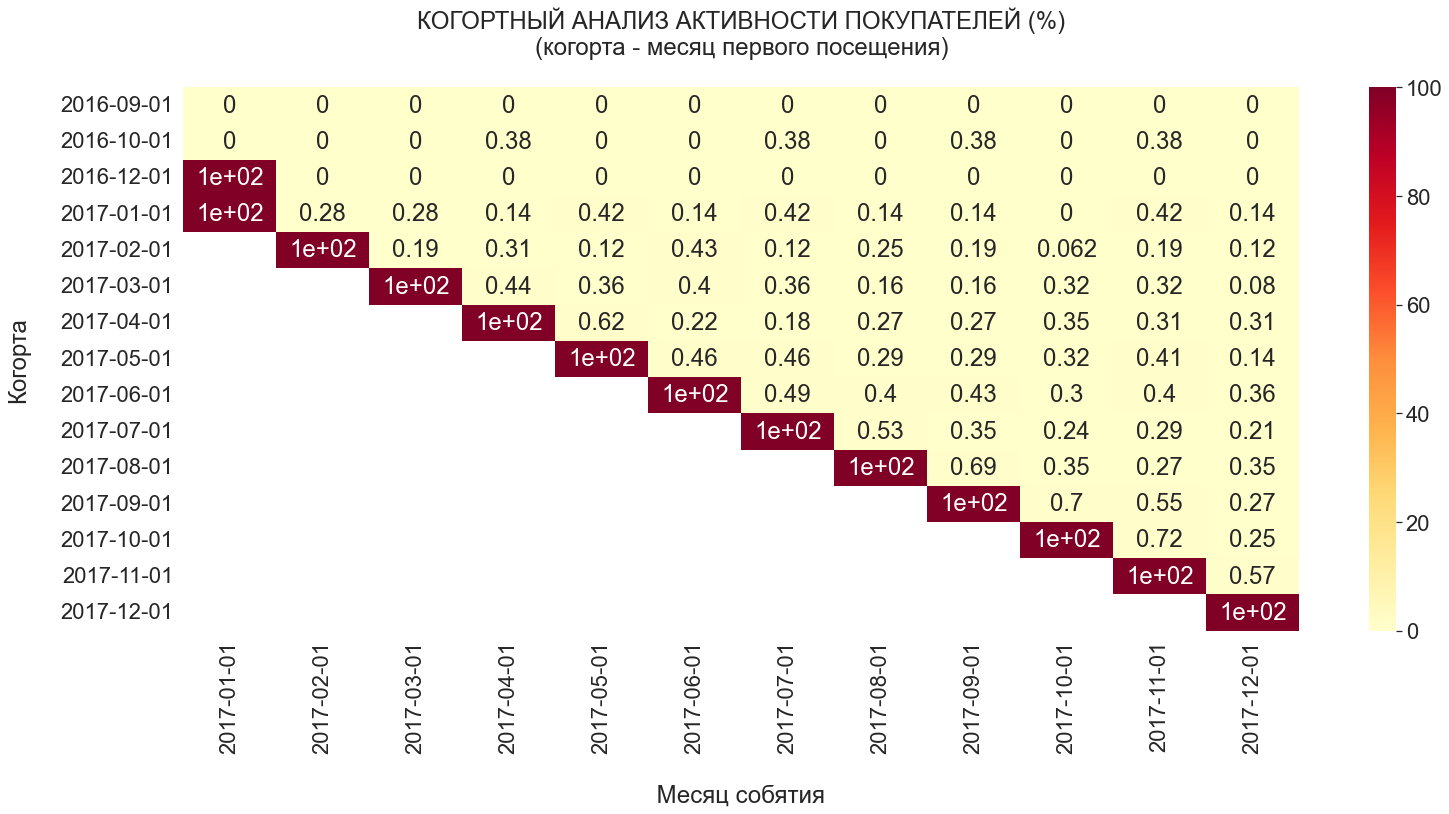

In [62]:
# выведем на график хитмеп для удобсвта : 
ax = sns.heatmap(retention, annot=True,  cmap = 'YlOrRd')
ax.set_title('КОГОРТНЫЙ АНАЛИЗ АКТИВНОСТИ ПОКУПАТЕЛЕЙ (%)\n(когорта - месяц первого посещения)\n')
ax.set_xlabel('\n Месяц собятия ')
ax.set_ylabel('Когорта\n')
plt.show()

In [63]:
# Создадим сводную таблицу : Индекс - дата первой покупки (data_order_purchase) , колонки -годичный интервал ( помесячно )
# Сразу посчитаем количество активных  используя функцию - сумма 
retention_abs = report.pivot_table(index='data_order_purchase',columns='month',values='active',aggfunc='sum')


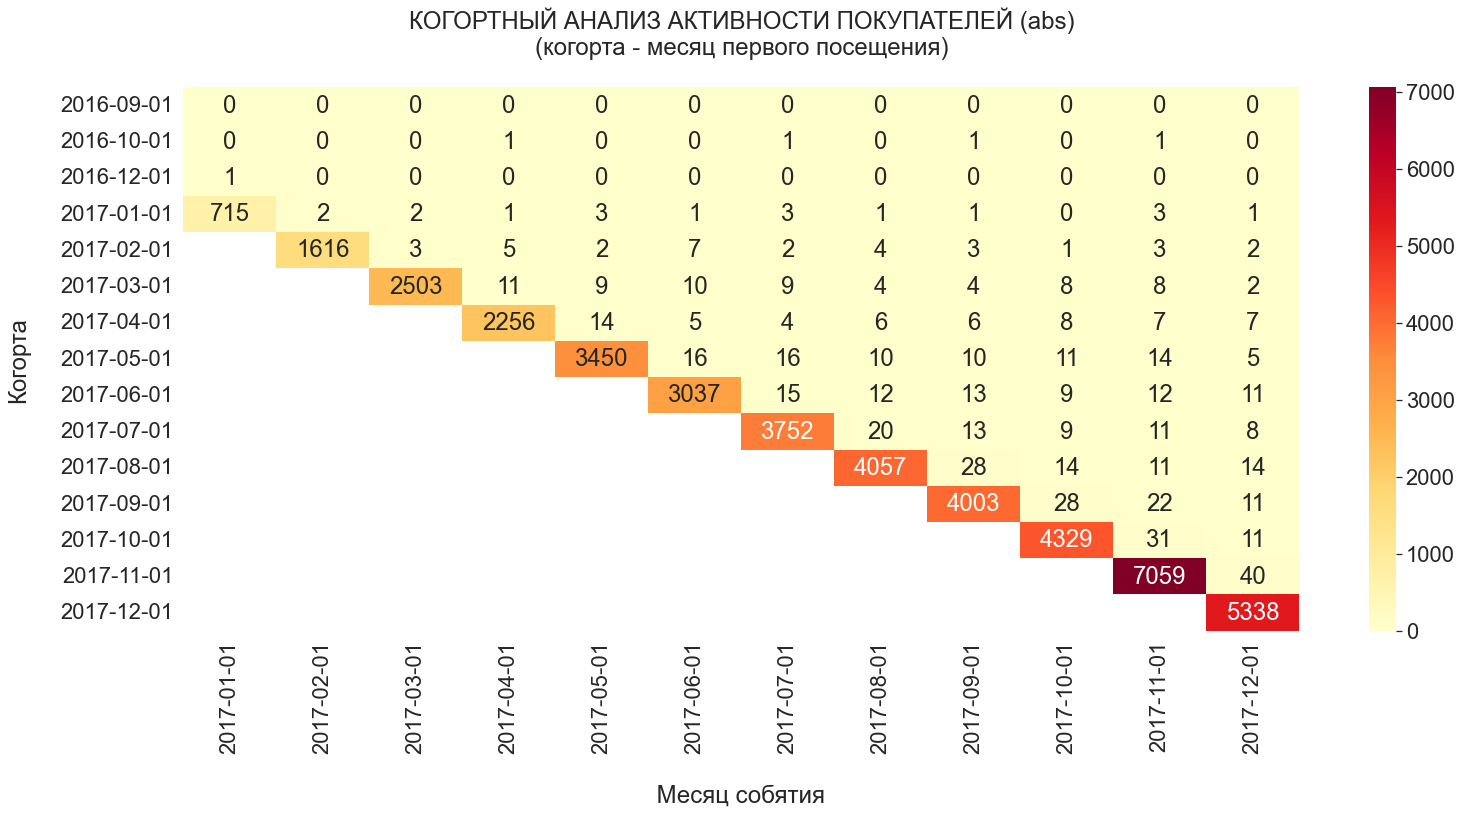

In [64]:
# выведем на график хитмеп для удобсвта : 
ax = sns.heatmap(retention_abs, annot=True, fmt='.0f',  cmap = 'YlOrRd')
ax.set_title("КОГОРТНЫЙ АНАЛИЗ АКТИВНОСТИ ПОКУПАТЕЛЕЙ (abs)\n(когорта - месяц первого посещения)\n")
ax.set_xlabel('\n Месяц собятия ')
ax.set_ylabel('Когорта\n')
plt.show()

In [65]:
# В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц:
#1.Мы видим что в третьем месяце ( 2017-03-01) когорта с самым  высоким retention == 2017-09-01 (0.55%)
#2.Вернулись и купили всего 22 пользователя 
#3.Размер когорты - 4003

6.Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю

In [66]:
# Определим какие данные нам нужны для проведения RFM-сегментации:
# 1.Уникальный номер ( паспорт)
# 2.Номер чека 
# 3.Стоимость товара 
# 4.Дата покупки товара 
# 5.Дата последней покупки товара  


In [67]:
# В данном ДФ (olist_order_items_dataset) отобраны ТОЛЬКО Успешные покупки, обратим внимание что все колонки нам не нужны: 
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [68]:
# Найдем сумму покупки в каждом чеке,отберем нужные колонки, перезапишем в новый ДФ: 
new_order_price = olist_order_items_dataset.groupby('order_id',as_index=False).sum('price')[['order_id','price']]
new_order_price.head()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [69]:
# Объеденим два ДФ, для нахождения наших RFM в дальнейшем:
template_RFM = new_order_price.merge(all_customers_orders_dataset[['customer_unique_id','order_id',\
                                                                   'order_purchase_timestamp']],\
                                                                    how='left',on='order_id')

In [70]:
# Для дальнейшего подсчета разницы в днях преобразуем нашу колонку с датами в временнной формат: 
template_RFM['order_purchase_timestamp'] = pd.to_datetime(template_RFM['order_purchase_timestamp'])
template_RFM

,order_id,price,customer_unique_id,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,239.90,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,199.00,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,12.99,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51
...,...,...,...,...
96450,fffc94f6ce00a00581880bf54a75a037,299.99,0c9aeda10a71f369396d0c04dce13a64,2018-04-23 13:57:06
96451,fffcd46ef2263f404302a634eb57f7eb,350.00,0da9fe112eae0c74d3ba1fe16de0988b,2018-07-14 10:26:46
96452,fffce4705a9662cd70adb13d4a31832d,99.90,cd79b407828f02fdbba457111c38e4c4,2017-10-23 17:07:56
96453,fffe18544ffabc95dfada21779c9644f,55.99,eb803377c9315b564bdedad672039306,2017-08-14 23:02:59


In [71]:
# Узнаем дату последнего заказа == мах.от даты последнего заказа в колонке Дат:
template_RFM['order_purchase_timestamp'].max()

Timestamp('2018-08-29 15:00:37')

In [72]:
#Это будет нашим ориентиром для  точки отсчета : NOW
NOW = template_RFM['order_purchase_timestamp'].max()    


In [73]:
# C помощью ДФ 'template_RFM ' посчитаем наши показатели 
# 1.Последнюю дату покупки пользователем (last_day_purchase) - функия max от даты , 
# 2.Общее количество покупок соверщенных пользователем за все время (Frequency) - функция count от покупок пользователя
# 3.Общую сумму покупок пользователя за все время (Monetary) - функция sum от всех покупок пользователя
 
RFM=template_RFM.groupby('customer_unique_id',as_index=False).agg({'order_purchase_timestamp':'max',\
                                                                    'order_id':'count',\
                                                                    'price':'sum'})\
                                                              .rename(columns=\
                                                                     {'order_purchase_timestamp':'last_day_purchase',\
                                                                     'order_id':'Frequency',\
                                                                     'price':'Monetary'})
RFM.head()

,customer_unique_id,last_day_purchase,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00


In [74]:
# Разница между Самой последней покупкой вообще(NOW) и последней датой покупки пользователя , выраженная в днях 
# даст нам искомое Recency за все время : 
RFM['Recency'] = (NOW - RFM.last_day_purchase).dt.days
RFM = RFM[['customer_unique_id','Recency','Frequency','Monetary']]
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,536,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00


Анализ RFM основан бальной сиситеме , для каждой нашей колонки Мы определяем оценку - в зависимости от данных, чем Выше оценка - тем наши данные должны быть успешней: Количество дней с последней покупки меньше, общее число покупок высокое, сумма покупки так же большая! 
Всю разбивку по баллам мы можем провести в ручную, самостоятельно разбив на категории. 
В питоне есть функция quintile, которая разбивает по сегментам


In [75]:
# Данные для сегментов мы создали , посмотрим чуть подробней на сколько частей стоит разбить их 
RFM.describe()

,Recency,Frequency,Monetary
count,93336.000000,93336.000000,93336.000000
mean,236.903853,1.033417,141.621663
std,152.552964,0.209098,215.714143
min,0.000000,1.000000,0.850000
25%,113.000000,1.000000,47.650000
50%,218.000000,1.000000,89.700000
75%,345.000000,1.000000,154.692500
max,713.000000,15.000000,13440.000000


В данных отчетливо видно, что гибко разбить по категориям получится только 2 колонки : Recency , Monetary.
Колонку Frequency - разобьем вручную. 

In [76]:
# Разобьем наши  данные Recency , Monetary с помощью квантилей на 4 части ( будет 5 категорий : 
quintiles = RFM[['Recency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 91.0, 0.4: 176.0, 0.6: 267.0, 0.8: 381.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [77]:
# Функция пробегающая по колонке Recency - чем меньше времени(количества дней) с последней покупки, тем БАЛ ВЫШЕ!:
# Разбивка по дням от последней покупки:
 # 5 - 0   до 91  дней      
 # 4 - 92  до 176 дней
 # 3 - 177 до 267 дней 
 # 2 - 268 до 381 дней 
 # 1 - 382 до 713 дней
    
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1


In [78]:
# Функция пробегающая по колонке Frequency - и начисляющая балы, чем меньше заказов - тем меньше бал:
# категории количества покупок : 
 # 1 - покупка  1    раз 
 # 2 - покупка  2    раза
 # 3 - покупка  3-4  раза 
 # 4 - покупка  5-6  раз 
 # 5 - покупка  7-15 раз 
    
def f_score(x):
    if x == 1:
        return 1
    elif x ==2:
        return 2
    elif x <= 4:
        return 3
    elif x <= 6:
        return 4
    else:
        return 5 

In [79]:
# Функция пробегающая по Monetary и начисляющая балы, чем меньше денег потрачено -  тем  меньше бал: 
# категории суммы : 
 # 1 -  0      до  39,9  $
 # 2 -  39,91  до  69,9  $
 # 3 -  69,91  до  109,9 $
 # 4 -  109,91 до  179,9 $
 # 5 -  179,91 до  13440 $
    
def m_score(x):
    if x <= quintiles['Monetary'][.2]:
        return 1
    elif x <= quintiles['Monetary'][.4]:
        return 2
    elif x <= quintiles['Monetary'][.6]:
        return 3
    elif x <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5 

In [80]:
# Используем формулу для обозначения категории в Recency :
RFM['R'] = RFM['Recency'].apply(lambda x: r_score(x))

In [81]:
# Используем формулу для обозначения категории в Frequency: 
RFM['F']  = RFM['Frequency'].apply(lambda x: f_score(x))

In [82]:
# Используем формулу для обозначения категории в Monetary :
RFM['M'] = RFM['Monetary'].apply(lambda x: m_score(x))

In [83]:
RFM

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,4,1,1
2,0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,5
...,...,...,...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,446,1,1570.00,1,1,5
93332,fffea47cd6d3cc0a88bd621562a9d061,261,1,64.89,3,1,2
93333,ffff371b4d645b6ecea244b27531430a,567,1,89.90,1,1,3
93334,ffff5962728ec6157033ef9805bacc48,118,1,115.00,4,1,4


In [84]:
# Создадим колонку с RFM кодом : 
RFM['RFM_Score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)

In [85]:
# Отсортируем: 
RFM.sort_values('RFM_Score',ascending= True)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
43238,767549358fd334e4d71723e547d43fd1,428,1,36.90,1,1,1,111
27611,4ba1a2e07dfdd6f3224561707860785b,490,1,25.99,1,1,1,111
3171,0892c1b4ceb4a62704abbb711a74c4dd,455,1,23.49,1,1,1,111
77083,d3108956b7d3e29b613600338ad7b8dc,460,1,35.00,1,1,1,111
27603,4b9d5d97bd2fe143891cf91ac7ca1116,447,1,34.90,1,1,1,111
...,...,...,...,...,...,...,...,...
80519,dc813062e0fc23409cd255f7f53c7074,6,6,687.76,5,4,5,545
28646,4e65032f1f574189fb793bac5a867bbc,76,5,404.57,5,4,5,545
36700,6469f99c1f9dfae7733b25662e7f1782,62,7,664.20,5,5,5,555
51421,8d50f5eadf50201ccdcedfb9e2ac8455,8,15,714.63,5,5,5,555


RFM-сегмент 545 (Recency= 5, Frequency=4, Monetary=5) имеет границы метрик Recency от 0 до 91 дней, Frequency от 5 до 6
заказов за весь период, Monetary (общая сумма покупки ) от 179,91 $  до 13340 $ за весь преиод!